## The purpose of this notebook is to test the performance of the anchor statistic in detecting deviation from population continuity. We also perform some tests of the sensitivity of this statistic to various forms of possible bias. We accomplish this by:

### 1) Simulating data under two demographic models, one with strong private drift in one branch, and another with constant population sizes but pulses of admixture from an unsampled source population.

### 2) Compute genetic drift through time in both scenarios.

### 3) Calculate the anchor statistic: using the oldest sampled individual as the anchor and conditioning on heterozygous sites in that individual, count the proportion of derived alleles at those sites in all other individuals. Visualize the change in the anchor statistic through time. 

### 4) Since inferences are based on proportions of mismatches (lack of derived alleles at sites that are heterozygous in the anchor), false negatives have the potential to bias this statistic. This is generally the case for any statistic measuring genetic distance - upwards bias can result from inaccurate allele frequency counts and missing data characteristic of samples with low coverages. A few scenarios to consider:
####    - miscalling of heterozygote sites in the anchor individual. If genuine heterozygote sites are miscalled as homozygotes, the result will be that these sites are not included in downstream analyses. This error type primarily affects the statistical power of the approach. How sensitive is the method to the number of heterozygous sites used? To address this, we downsample the number of anchor heterozygote sites used for inference, and study the impact on the anchor statistic.
####   - if on the other hand genuine homozygote sites in the anchor are miscalled as heterozygotes (false positives), these sites will be assessed in test individuals. This type of genotyping error at a particular site is not expected to be correlated across individuals. With real data, we set data quality thresholds for the calling of heterozygous sites in the anchor individual, and then randomly choose a single allele at each of those sites in a test individual. This is a common approach to dealing with the problems of low coverage and sequencing error in ancient data. Here we employ a similar approach, simulating a high sequencing error rate, and assessing the impact on estimation of the anchor statistic.
####    - if the test individuals have low coverage and genuine derived alleles are not detected at anchor sites. We only consider a site informative if it has a minimum coverage of 4 reads, and we randomly select a single read at that site. 

In [19]:
import msprime as msp
import random
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import math
from itertools import combinations, permutations
import matplotlib as mpl
%matplotlib inline
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import allel; print('scikit-allel', allel.__version__)
from allel.stats.misc import jackknife
import sys
from scipy.spatial import distance
from matplotlib import gridspec
import scipy.stats as st
import matplotlib.lines as mlines

scikit-allel 1.3.8


## Global togle to save / not-save figures

In [20]:
isSaveFigures = True

# adjust some font params
plt.rcParams.update({'font.size': 14})
plt.rc('legend',fontsize='12')

# Functions to downsample perfect simulated data and introduce aDNA damages

In [21]:
### MAKE EMPTY GENOTYPE ARRAY ····························································
def empty_genotype_array(n_loci, n_samples, ploidy=2, allele=-1):
    """
    Creates a genotype array with all values as missing (-1) for a given number
    of samples, loci and ploidy

    :return: empty_ga
    """
    empty_ga = allel.GenotypeArray(np.full((n_loci, n_samples, ploidy), allele, dtype='i1'), dtype='i1')
    return empty_ga
  
def test_empty_genotype_array():
    test_ga = empty_genotype_array(3, 4, ploidy=2, allele=-1)
    assert type(test_ga) is allel.model.ndarray.GenotypeArray
    assert len(test_ga) == 3
    assert all(test_ga[0,0] == [-1,-1])
    assert all(test_ga[2,3] == [-1,-1])
    test_ga = empty_genotype_array(3, 4, ploidy=2, allele=0)
    assert all(test_ga[1,1] == [0,0])
### end MAKE EMPTY GENOTYPE ARRAY ····························································


### SNP CALLING FROM SIMULATED READS (WITH SEQUENCING ERROR)  ····························
def snp_calling(true_genotype, f_num_reads, error_rate=0.01, reads_th=8, ratio_th=1/3, damage=False, transversion=True, is_anchor=False):
    """
    snp_calling function takes perfect simulated data from one locus of one 
    diploid individual and adds missing data and error according to the number 
    of reads of the site, error rate of the sequencing technology and, for 
    ancient DNA not sequenced from damage repair (dr) libraries, creates 
    missing data for transition SNPs (since they cannot be distinguished from
    aDNA damage)

    :param true_genotype:
    :param f_num_reads:
    :param error_rate:
    :param reads_th:
    :param score_th:
    :param ratio_th:
    :param dr:
    :param transversion:
    :return:
    """
    genotype_call = [-1, -1]  # Default to missing genotype
    if f_num_reads < 1:
        return genotype_call  # Early return if no coverage
    
    if damage is True and transversion is False:
        genotype_call = [-1, -1]

    # Simulate the number of derived reads based on the error model
    derived_count = sum(true_genotype)
    p_derived = derived_count / 2 * (1 - error_rate) + (1 - derived_count / 2) * error_rate
    derived_reads = st.binom.rvs(f_num_reads, p_derived)
    ancestral_reads = f_num_reads - derived_reads

    if is_anchor:
        if f_num_reads < reads_th:
            return genotype_call  # Not enough coverage for anchor
        
        # Apply specific rules for anchor individual
        if ancestral_reads == 0:
            genotype_call = [1, 1]
        elif derived_reads == 0:
            genotype_call = [0, 0]
        elif (ancestral_reads >= f_num_reads * ratio_th) and (derived_reads >= f_num_reads * ratio_th):
            genotype_call = [0, 1]
        else:
            genotype_call = [-1, -1]  # Not meeting the ratio threshold
    else:  # snp being called for a non-anchor individual
        all_reads = [0]*ancestral_reads + [1]*derived_reads
        if all_reads:
            chosen_allele = np.random.choice(all_reads, size=1, replace=True)
            genotype_call = chosen_allele.tolist()

    #print(genotype_call)
    return genotype_call

def test_snp_calling():
    np.random.seed(1234)
    genotype_call = snp_calling( [0, 1], 100, error_rate=0.005, reads_th=1,
                  score_th=10, ratio_th=3, damage=False, transversion=True)
    assert genotype_call == [0,1]
    genotype_call = snp_calling( [0, 1], 1, error_rate=0.005, reads_th=10,
                  score_th=10, ratio_th=3, damage=False, transversion=True)
    assert genotype_call == [-1,-1]
### end SNP CALLING FROM SIMULATED READS (WITH SEQUENCING ERROR)  ····························

### SIMULATE SEQUENCING  ····························
def sequencing(ts, ssize, ttr, seq_error, damage, cov, anchor_index=6):
    if len(cov) != ssize:
        msg = "Number of coverage values (length=" + str(len(cov)) + \
              ") and number of samples (ssize=" + str(ssize) + \
              ") do not match"
        raise ValueError(msg)

    geno_data = empty_genotype_array(n_loci=ts.num_sites,
                                   n_samples=ssize,
                                   ploidy=2)
    positions = []
    locus = 0
    for variant in ts.variants():
        positions.append(round(variant.position))
        #print(variant.position)
        var_genotypes = variant.genotypes
        #print("variant genotypes = ", var_genotypes)
        num_reads = np.random.poisson(lam=cov, size=ssize)
        #print("num_reads = ", num_reads)
        transversion_snp = np.random.random() < ttr / (ttr + 1)

        for i in range(0, 2 * ssize, 2):
            if len(variant.alleles)==2:
                is_anchor = (int(i / 2) == anchor_index)
                gt_call = snp_calling(true_genotype = var_genotypes[i:(i + 2)],
                                      f_num_reads = num_reads[int(i / 2)],
                                      error_rate=seq_error,
                                      damage = damage[int(i / 2)],
                                      transversion = transversion_snp,
                                      is_anchor=is_anchor)
            else:
                gt_call = [-1, -1] # this removes all SNP with more than two alleles
            geno_data[locus, int(i / 2)] = gt_call
        locus += 1
        #print(locus)
    return geno_data, positions

# msprime simulations

First use msprime to generate data under two simple topologies. Idea here is to demonstrate that alternative demographies can give rise to qualitatively similar patterns of genetic variation and summary statistics (PCA). 
This run, recombination rate = 1.25 e-8, mutation rate = 1.45 e-8, generation time = 29 years. 7 samples are taken from 2 populations at 2 different time points (modern and ancient).

In [22]:
# fixed parameters
gen_time = 29
L = 2000000
mu = 1.45e-8 # equates to 0.5e-9/yr
r = 1.25e-8

# Demographic model 1

### Fixed splits, admixture dates and fractions:

In [23]:
t_AB_split = 4000

# Population sizes
popA_N_start = 10000  
popA_N_end = 1000 
popB_N = 10000
popAB_N = 10000
popA_rate = -np.log(popA_N_end/popA_N_start) / t_AB_split # calculate growth rate required to decrease popA from start to end size (backwards in time)

# build msprime demographies
demography1 = msp.Demography()
demography1.add_population(name="PA", initial_size=popA_N_start, growth_rate=popA_rate, default_sampling_time=0)
demography1.add_population(name="PB", initial_size=popB_N, default_sampling_time=0)
demography1.add_population(name="PAB", initial_size=popB_N, default_sampling_time=t_AB_split)
demography1.add_population_split(time=t_AB_split, derived=['PA','PB'], ancestral='PAB') # add the fixed split to msprime's demography
demography1.sort_events()

### Choose samples to take from demographic objects

In [24]:
def set_up_samples(tS):
    samples = [msp.SampleSet(num_samples=1, population=0, time=tS[0], ploidy=2)] # Series of samples taken at different times from popA
    samples.extend([msp.SampleSet(num_samples=1, population=0, time=tS[1], ploidy=2)]) 
    samples.extend([msp.SampleSet(num_samples=1, population=0, time=tS[2], ploidy=2)]) 
    samples.extend([msp.SampleSet(num_samples=1, population=0, time=tS[3], ploidy=2)]) 
    samples.extend([msp.SampleSet(num_samples=1, population=0, time=tS[4], ploidy=2)]) 
    samples.extend([msp.SampleSet(num_samples=1, population=0, time=tS[5], ploidy=2)]) 
    samples.extend([msp.SampleSet(num_samples=1, population=0, time=tS[6], ploidy=2)]) 
    return samples

tS=[0,120,240,360,480,600,720]
Samples = set_up_samples(tS)

In [25]:
numRuns=1000 # the number of independent simulations to run for a given demography

In [26]:
for aRun in range(numRuns):
    ts1 = msp.sim_ancestry(
        samples = Samples,
        demography=demography1,
        recombination_rate=r,
        sequence_length=L,
        model=[msp.DiscreteTimeWrightFisher(duration=50), msp.StandardCoalescent()],
        random_seed=None
    )
    # This generates an ancestral history for samples. If we want genome sequence we must also simulate mutations on these trees. 
    # Note I am running Discrete Time Wright Fisher model for time=50. This is to better model long-range LD when simulating long sequences. This
    # is only an issue in recent past, and then I revert to standard coalescent model. Slows simulations, but may remove spurious high LD.
    # Given an input tree sequence, superimpose mutations on that ancestral history.  
    
    mut_treesq1 = msp.sim_mutations(ts1, rate=mu, random_seed=None)
    
    # pipe perfect simulation results through functions to add errors and make comparable to empirical data
    chrono_order_is_damaged = np.repeat(np.array([True,False], dtype=bool), [0,7])
    covs = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 8.0]) # coverages of all samples
#    repeats = np.array([7])
#    chrono_order_coverage = np.repeat(covs, repeats)

    geno_data1, positions1 = sequencing(ts = mut_treesq1,
                                  ssize = 7,
                                  ttr = 2.1,
                                  seq_error = 0.01,
                                  damage = chrono_order_is_damaged,
                                  cov = covs)

    # Export the genotype data to allel. Unfortunately there's a slight mismatch in the terminology here where genotypes and haplotypes mean different things in the two libraries.
    if aRun == 0:
        geno_arr1 = geno_data1
        pos_list1 = positions1
    else:
        geno_arr1 = np.concatenate((geno_arr1,geno_data1),axis=0) # stack arrays row-wise
        pos_list1.extend(x+(aRun*L) for x in positions1) # keep adding current length of simulated sequence to positions
geno_arr1 = allel.GenotypeArray(geno_arr1, dtype='i1')

### Save / load data as numpy arrays

In [27]:
np.save('LowCov_SeqError/GenoMatModel1.npy', geno_arr1)
#geno_arr1 = np.load('GenoMatModel1.npy')
#geno_arr1 = allel.GenotypeArray(geno_arr1, dtype='i1')

In [28]:
# First get haplotype array for all samples in each  results matrix
def pop_sample_ac(geno_arr):
    ac_1 = geno_arr[:,6:7].count_alleles()
    ac_2 = geno_arr[:,5:6].count_alleles()
    ac_3 = geno_arr[:,4:5].count_alleles()
    ac_4 = geno_arr[:,3:4].count_alleles()
    ac_5 = geno_arr[:,2:3].count_alleles()
    ac_6 = geno_arr[:,1:2].count_alleles()
    ac_7 = geno_arr[:,0:1].count_alleles()
    arrays = [ac_1,ac_2,ac_3,ac_4,ac_5,ac_6,ac_7]  # stack arrays
    return arrays
ac_samples_1 = pop_sample_ac(geno_arr1)

# Ignore some warnings when calculating summary stats with missing data, typically on Tajima's D and Fst (division by zero, etc) 
np.seterr(invalid='ignore',divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [29]:
populations = np.array(['1', '2', '3', '4', '5', '6', '7'], dtype=object)
pop_colours = {
    '1': '#FF0000',
    '2': '#008000',
    '3': '#00FFFF',
    '4': '#90EE90',
    '5': '#FFA500',
    '6': '#8B0000',
    '7': '#1E90FF'
}

# Demographic model 2

# Set up the demographic model

In [30]:
# Admixture times (gens) and proportions
adm_t1, adm_frac1 = 420, 0.25 
adm_t2, adm_frac2 = 180, 0.25

# build msprime demographies
demography2 = msp.Demography()
demography2.add_population(name="PA", initial_size=popA_N_start, growth_rate=popA_rate, default_sampling_time=0)
demography2.add_population(name="PB", initial_size=popB_N, default_sampling_time=0)
demography2.add_population(name="PAB", initial_size=popB_N, default_sampling_time=t_AB_split)
demography2.add_population_split(time=t_AB_split, derived=['PA','PB'], ancestral='PAB') # add the fixed split to msprime's demography
demography2.add_mass_migration(time=adm_t1, source='PA', dest='PB', proportion=adm_frac1) # equivalent to PB to PA forwards in time
demography2.add_mass_migration(time=adm_t2, source='PA', dest='PB', proportion=adm_frac2) # equivalent to PB to PA forwards in time
demography2.sort_events()

In [31]:
## Run simulations for model 2
for aRun in range(numRuns):
    ts2 = msp.sim_ancestry(
        samples = Samples,
        demography=demography2,
        recombination_rate=r,
        sequence_length=L,
        model=[msp.DiscreteTimeWrightFisher(duration=50), msp.StandardCoalescent()],
        random_seed=None
    )
    mut_treesq2 = msp.sim_mutations(ts2, rate=mu, random_seed=None)
    
    # pipe perfect simulation results through functions to add errors and make comparable to empirical data
    chrono_order_is_damaged = np.repeat(np.array([True,False], dtype=bool), [0,7])
    covs = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 8.0])
#    repeats = np.array([7])
#    chrono_order_coverage = np.repeat(covs, repeats)
    geno_data2, positions2 = sequencing(ts = mut_treesq2,
                                  ssize = 7,
                                  ttr = 2.1,
                                  seq_error = 0.01,
                                  damage = chrono_order_is_damaged,
                                  cov = covs) 
    # Export the genotype data to allel. Unfortunately there's a slight mismatch in the terminology here where genotypes and haplotypes mean different things in the two libraries.
    if aRun == 0:
        geno_arr2 = geno_data2
        pos_list2 = positions2
    else:
        geno_arr2 = np.concatenate((geno_arr2,geno_data2),axis=0) # stack arrays row-wise
        pos_list2.extend(x+(aRun*L) for x in positions2) # keep adding current length of simulated sequence to positions
geno_arr2 = allel.GenotypeArray(geno_arr2, dtype='i1')

In [32]:
np.save('LowCov_SeqError/GenoMatModel2.npy', geno_arr2)
#geno_arr2 = np.load('GenoMatModel2.npy')
#geno_arr2 = allel.GenotypeArray(geno_arr2, dtype='i1')

In [33]:
# First get haplotype array for all samples in each results matrix
ac_samples_2 = pop_sample_ac(geno_arr2)

### Load in demographic model data as numpy arrays

In [34]:
#geno_arr1 = np.load('Genoarr1.npy')
#geno_arr1 = allel.GenotypeArray(geno_arr1, dtype='i1')
#geno_arr2 = np.load('Genoarr2.npy')
#geno_arr2 = allel.GenotypeArray(geno_arr2, dtype='i1')
#ac_samples_1 = pop_sample_ac(geno_arr1)
#ac_samples_2 = pop_sample_ac(geno_arr2)

In [35]:
geno_arr2

<GenotypeArray shape=(3221053, 7, 2) dtype=int8>
0/0 ./. 0/0 ./. 0/0 0/0 0/0
0/0 1/1 1/1 1/1 ./. 1/1 0/0
0/0 ./. 0/0 0/0 ./. 1/1 0/0
...
./. 0/0 ./. ./. 0/0 ./. ./.
0/0 0/0 0/0 ./. ./. 0/0 ./.
0/0 0/0 ./. 0/0 0/0 ./. ./.

# Anchor statistic

### Downsample array to sites that are heterozygous in the given anchor

In [36]:
def get_anc_subset(full_arr, anchor):
    """
    Function to get subset of sites that are heterozygous in a given anchor individual
    """
    mask = full_arr[:,anchor-1,:].sum(axis=1)==1
    masked_arr = full_arr[mask,:,:]
    return masked_arr

anchor1_mat1 = get_anc_subset(geno_arr1,7) # the last sample is the oldest
#np.save('AnchorHeterozygotes_Model1.npy', anchor1_mat1)
anchor1_mat2 = get_anc_subset(geno_arr2,7)
#np.save('AnchorHeterozygotes_Model2.npy', anchor1_mat2)

In [37]:
anchor1_mat1

<GenotypeArray shape=(290649, 7, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ./. 0/1
0/0 ./. ./. ./. 0/0 0/0 0/1
0/0 ./. ./. 0/0 ./. ./. 0/1
...
./. 0/0 ./. 0/0 ./. 0/0 0/1
./. 0/0 0/0 0/0 ./. 0/0 0/1
0/0 ./. 0/0 0/0 ./. 1/1 0/1

In [38]:
#anchor1_mat1 = np.load('AnchorHeterozygotes_Model1.npy')
#anchor1_mat2 = np.load('AnchorHeterozygotes_Model2.npy')

### Get pseudohaploidized array and count derived in each individual

In [39]:
def get_pseudo_prop(x_arr):
    """
    Function to calculate the proportion of pseudo-haploidized derived alleles,
    ignoring missing data represented by -1.
    """
    # Filter out missing data and flatten the array
    filtered_arr = x_arr[x_arr >= 0]
    if filtered_arr.size == 0:
        return np.nan  # Return NaN if all data are missing to avoid division by zero

    # Randomly select alleles for the pseudo-haploid genotype
    pseudohap_arr = np.random.choice(filtered_arr, size=filtered_arr.size//2, replace=False)

    # Calculate the proportion of derived alleles (which are '1')
    prop_derived = np.mean(pseudohap_arr)
    return prop_derived

# Function to compute the mean and SE of derived proportions using a moving window
def get_prop_der(ind_arr, blen):
    """
    Compute the proportion of derived alleles within each block and return the mean
    and standard error across all blocks, handling missing data appropriately.
    """
    # Use moving_statistic to apply get_pseudo_prop across blocks
    b_prop_der = allel.moving_statistic(ind_arr, get_pseudo_prop, size=blen)
    
    # Calculate mean and standard error, ignoring NaNs
    valid_props = b_prop_der[~np.isnan(b_prop_der)]  # Ignore NaN values
    if valid_props.size == 0:
        return np.nan, np.nan  # Return NaN if all blocks are invalid

    m = np.mean(valid_props)
    se = np.std(valid_props, ddof=1) / np.sqrt(valid_props.size)
    return m, se

# calculate the number of windows to use in jackknife estimation of confidence intervals. In real data we use 5Mb windows, each on average containing ~5000 heterozygous sites.
# To build confidence intervals similarly for the simulated data, here I estimate the window size that contains ~5000 heterozygous sites, and use that to build intervals.
window_size = int(min(anchor1_mat1.shape[0], anchor1_mat2.shape[0]) / 5000)

propder_anchor1_mat1 = np.array([(get_prop_der(x, window_size)) for x in anchor1_mat1.transpose(1, 0, 2)])
propder_anchor1_mat2 = np.array([(get_prop_der(x, window_size)) for x in anchor1_mat2.transpose(1, 0, 2)])

In [62]:
# Define function to plot proportion derived vs inds on x axis. 
def plot_prop_der(der_arr1, der_arr2, title=None):
    """
    Plot the anchor statistic. Takes an array of proportion derived for two datasets and outputs line plot showing reduction in proportion derived.
    """
    inds = [str(x) for x in list(range(2,8))][::-1]
    y1 = der_arr1[:,0]
    y2 = der_arr2[:,0]
    sterr1 = 1.96*(der_arr1[:,1])
    sterr2 = 1.96*(der_arr2[:,1])
    x = inds
    fig, ax = plt.subplots(figsize=(6, 8))
    #sns.despine(ax=ax, offset=10)
    ax.errorbar(y1, x, xerr=sterr1, marker='o', label="Private drift")
    ax.errorbar(y2, x, xerr=sterr2, marker='o', label="Admixture")
    # Adding horizontal dashed red lines
    ax.axhline(y=3.5, color='r', linestyle='--', label='Pulse of 25% admixture')
    ax.axhline(y=1.5, color='r', linestyle='--')  # Not labeling again to avoid duplicate in legend
    ax.set_ylabel('Sample', labelpad=20)
    ax.set_xlabel('Proportion derived', labelpad=20)
#    lower, upper = np.min(y2)-0.01, np.max(y1)+0.015
    ax.set_xlim(0.30, 0.42)
    ax.legend(loc=2, title="Simulated model")
    sample_times = [str(x) for x in list(range(0,720,120))][::-1]
    ax2 = ax.twinx()
    ax2.plot(y1,sample_times)
    ax2.set_ylabel('time (generations)', labelpad=20)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(16)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)        
    fig.tight_layout()
    if title:
        ax.set_title(title)
    if isSaveFigures:
        plt.savefig('LowCov_SeqError/AnchorS1_bothModels.png', dpi=300) 

### Using the oldest individual as the anchor:

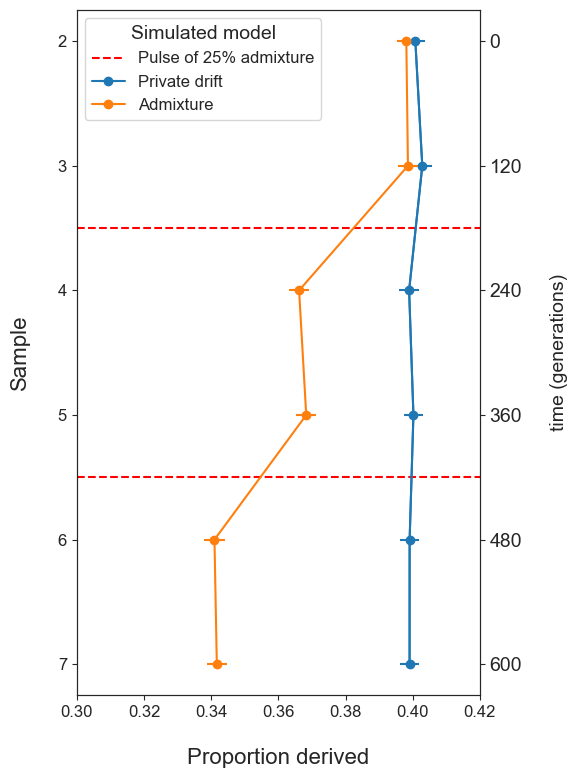

In [63]:
plot_prop_der(propder_anchor1_mat1[0:6,:], propder_anchor1_mat2[0:6,:])

## Power analysis
### Here we assess the impact of reducing number of anchor heterozygote sites on the anchor statistic. We do this by progressively thinning the dataset and recalculating anchor statistics across individuals.

In [42]:
def thin_data(array, proportion):
    """ Thin the data by randomly selecting a proportion of the anchor heterozygous sites used. """
    indices = np.random.choice(array.shape[0], int(array.shape[0] * proportion), replace=False)
    return array[indices]

In [64]:
def plot_prop_der(der_arr1, der_arr2, proportion, num_sites):
    """
    Plot the anchor statistic with thinned data, showing both demographic models in the same figure.
    """
    inds = [str(x) for x in list(range(2, 8))][::-1]  # Sample indices
    y1 = der_arr1[:, 0]  # Proportions from model A
    y2 = der_arr2[:, 0]  # Proportions from model B
    sterr1 = 1.96 * (der_arr1[:, 1])  # Standard errors for model A
    sterr2 = 1.96 * (der_arr2[:, 1])  # Standard errors for model B
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.errorbar(y1, inds, xerr=sterr1, marker='o', label="Private drift")
    ax.errorbar(y2, inds, xerr=sterr2, marker='o', label="Admixture")
    ax.axhline(y=3.5, color='r', linestyle='--', label='Pulse of 25% admixture')
    ax.axhline(y=1.5, color='r', linestyle='--')
    ax.set_xlabel('Proportion derived', labelpad=20, fontsize=20)
    ax.set_ylabel('Sample', labelpad=20, fontsize=20)
    ax.set_xlim(0.30, 0.42)
    ax.legend(loc=2, title="Simulated model")
    ax.set_title(f"{int(proportion * 100)}% Anchor sites: {num_sites}", fontsize=22, pad=10)
    sample_times = [str(x) for x in list(range(0,720,120))][::-1]
    ax2 = ax.twinx()
    ax2.plot(y1, sample_times)
    ax2.set_ylabel('time (generations)', labelpad=20, fontsize=20)
#    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
#        item.set_fontsize(16)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)        
    fig.tight_layout()
    filename = f'LowCov_SeqError/Anchor_S1_bothModels_{int(proportion * 100)}pct.png'
    if isSaveFigures:
        plt.savefig(filename, dpi=300)     
    plt.show()

In [44]:
def perform_analysis_and_plot(modelA_res, modelB_res, proportions):
    """ Perform analysis and plot for different data proportions for both demographic models. """
    for proportion in proportions:
        thinned_data1 = thin_data(modelA_res, proportion)
        thinned_data2 = thin_data(modelB_res, proportion)
        window_size = int(min(thinned_data1.shape[0], thinned_data2.shape[0]) / 5000)
        propder_anchor1 = np.array([(get_prop_der(x, window_size)) for x in thinned_data1.transpose(1, 0, 2)])
        propder_anchor2 = np.array([(get_prop_der(x, window_size)) for x in thinned_data2.transpose(1, 0, 2)])
        num_sites = int(np.mean([thinned_data1.shape[0], thinned_data2.shape[0]]))  # Mean number of sites after thinning
        
        plot_prop_der(propder_anchor1[0:6, :], propder_anchor2[0:6, :], proportion, num_sites)


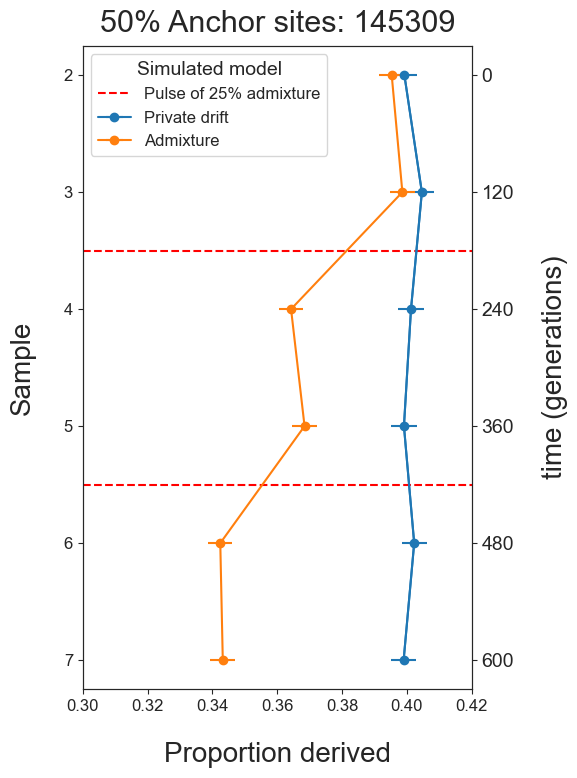

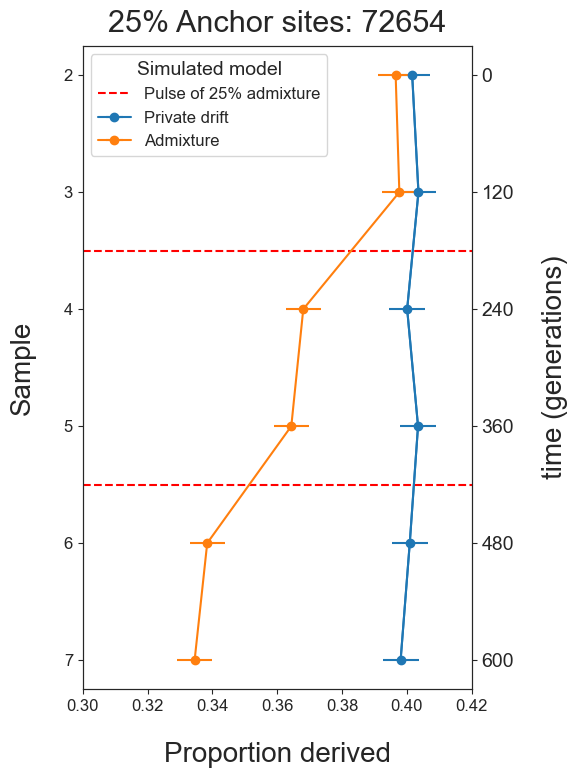

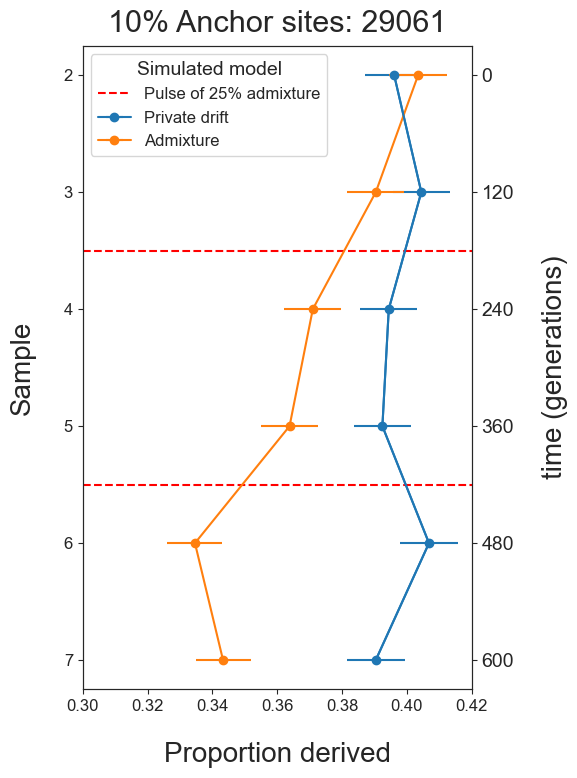

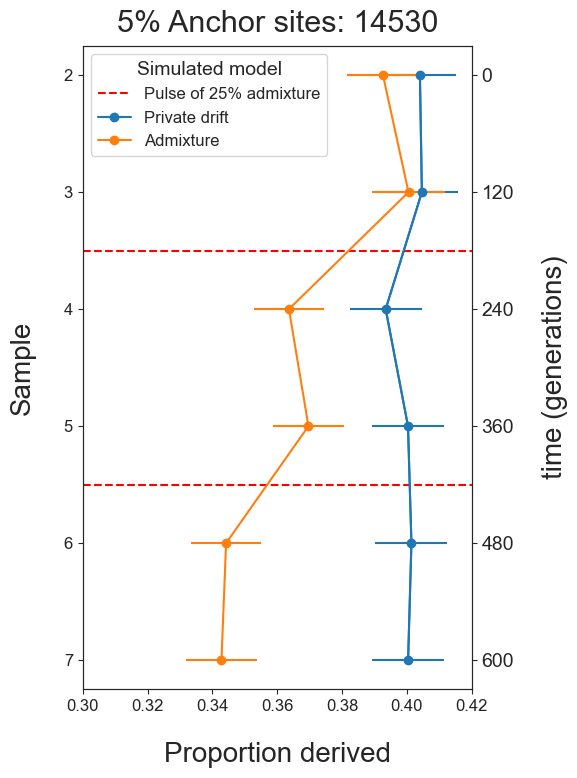

In [67]:
proportions = [0.5, 0.25, 0.1, 0.05]  # Different proportions to test
perform_analysis_and_plot(anchor1_mat1, anchor1_mat2, proportions)